In [27]:
import os
import librosa
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Data paths (update these to your actual paths)
file_path_real = '/content/drive/MyDrive/audios_FOR/amostra_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/amostra_FOR/fake'

In [30]:
# Função para inverter o áudio
def reverse_audio(y):
    return y[::-1]

In [31]:
# Função para extrair MFCCs de um arquivo
def extract_features(y, sr):  # Modificado para receber y e sr
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)  # Média dos coeficientes

# Carregar dados e rótulos
data = []
labels = []

In [32]:
def load_data_with_reverse(folder_path, label):
    global data, labels
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Extrair features do áudio original
            features = extract_features(y, sr)  # Passar y e sr
            data.append(features)
            labels.append(label)

            # Inverter o áudio e extrair features novamente
            y_reversed = reverse_audio(y)
            features_reversed = extract_features(y_reversed, sr)  # Passar y_reversed e sr
            data.append(features_reversed)
            labels.append(label)
        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

# Criar as pastas 'real' e 'fake' caso não existam
if not os.path.exists(file_path_real):
    os.makedirs(file_path_real)
if not os.path.exists(file_path_fake):
    os.makedirs(file_path_fake)

# Carregar dados
load_data_with_reverse(file_path_fake, 0)  # Rótulo 0 para Fake
load_data_with_reverse(file_path_real, 1)  # Rótulo 1 para Real

In [33]:
# Converter para DataFrame
df = pd.DataFrame(data)
df['label'] = labels

# Contar as ocorrências de cada label
label_counts = df['label'].value_counts()

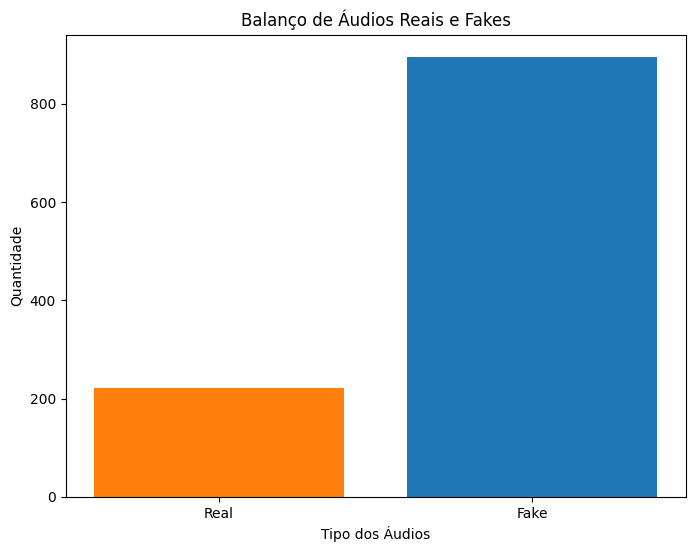

In [34]:
# Plotando o gráfico
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, tick_label=['Fake', 'Real'], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Tipo dos Áudios')
plt.ylabel('Quantidade')
plt.title('Balanço de Áudios Reais e Fakes')
plt.show()

In [35]:
df.shape

(1118, 14)

In [36]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Modelos
models = {
    "RandomForest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "LGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31, verbose=-1),
    "DecisionTree": DecisionTreeClassifier(criterion='gini', random_state=42)
}

# Treinar e avaliar modelos
for name, model in models.items():
    print(f"Treinando e avaliando {name}:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("-" * 50)

Treinando e avaliando RandomForest:
Acurácia: 0.97
Precisão: 0.97
Recall: 1.00
F1-Score: 0.98
--------------------------------------------------
Treinando e avaliando KNeighbors:
Acurácia: 0.92
Precisão: 0.94
Recall: 0.95
F1-Score: 0.95
--------------------------------------------------
Treinando e avaliando XGBoost:
Acurácia: 0.96
Precisão: 0.97
Recall: 0.98
F1-Score: 0.97
--------------------------------------------------
Treinando e avaliando LGBM:
Acurácia: 0.99
Precisão: 0.99
Recall: 1.00
F1-Score: 0.99
--------------------------------------------------
Treinando e avaliando DecisionTree:
Acurácia: 0.93
Precisão: 0.95
Recall: 0.95
F1-Score: 0.95
--------------------------------------------------


In [38]:
# Balançamento com Replicação
def balance_data(X_train, y_train):
    """Balanceia os dados de treinamento usando replicação."""
    counts = y_train.value_counts()
    major_class = counts.idxmax()
    minor_class = counts.idxmin()
    diff = counts[major_class] - counts[minor_class]

    # Identifica os índices da classe minoritária
    minor_indices = y_train[y_train == minor_class].index

    # Escolhe índices aleatórios para replicação
    add_indices = np.random.choice(minor_indices, size=diff, replace=True)

    # Adiciona as amostras replicadas aos dados de treinamento
    X_add = X_train.loc[add_indices]
    y_add = y_train.loc[add_indices]

    X_train_balanced = pd.concat([X_train, X_add])
    y_train_balanced = pd.concat([y_train, y_add])

    return X_train_balanced, y_train_balanced

X_train_balanced, y_train_balanced = balance_data(X_train, y_train)

In [39]:
# Treinar e avaliar modelos com dados balanceados
print("\nTreinando e avaliando com dados balanceados:")
print("-" * 50)
for name, model in models.items():
    print(f"Treinando e avaliando {name}:")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("-" * 50)


Treinando e avaliando com dados balanceados:
--------------------------------------------------
Treinando e avaliando RandomForest:
Acurácia: 0.97
Precisão: 0.98
Recall: 0.99
F1-Score: 0.98
--------------------------------------------------
Treinando e avaliando KNeighbors:
Acurácia: 0.92
Precisão: 0.99
Recall: 0.91
F1-Score: 0.95
--------------------------------------------------
Treinando e avaliando XGBoost:
Acurácia: 0.97
Precisão: 0.99
Recall: 0.98
F1-Score: 0.98
--------------------------------------------------
Treinando e avaliando LGBM:
Acurácia: 0.97
Precisão: 0.99
Recall: 0.98
F1-Score: 0.98
--------------------------------------------------
Treinando e avaliando DecisionTree:
Acurácia: 0.96
Precisão: 0.97
Recall: 0.98
F1-Score: 0.97
--------------------------------------------------
